In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import locale
import webbrowser
import os
import subprocess

locale.setlocale(locale.LC_TIME, 'Portuguese_Brazil.1252')

def converter_data_para_yyyymmdd(data):
    try:
        data_obj = pd.to_datetime(data, errors='raise')
        return data_obj.strftime('%Y%m%d')
    except ValueError as e:
        print(f"Erro ao converter a data: {e}")
        return None

def valor_irradiancia_media(lat, lon, start_date, end_date):
    start_day = converter_data_para_yyyymmdd(start_date)
    end_day = converter_data_para_yyyymmdd(end_date)
    
    if not start_day or not end_day:
        print(f"Datas inválidas: {start_date}, {end_date}")
        return None
    
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN&community=RE&longitude={lon}&latitude={lat}&format=JSON&start={start_day}&end={end_day}"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        data = response.json()
        if 'properties' in data and 'parameter' in data['properties']:
            irradiancia_diaria = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
            
            if len(irradiancia_diaria) == 0:
                print(f"Nenhum dado de irradiância disponível para o período: {start_date} a {end_date}")
                return None
            
            irradiancia_media = sum(irradiancia_diaria.values()) / len(irradiancia_diaria)
            return irradiancia_media
        else:
            print("Dados de irradiância não encontrados na resposta.")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Erro na requisição: {e}")
        return None
    except (ValueError, KeyError) as e:
        print(f"Erro ao processar os dados da API: {e}")
        return None

def energia_gerada(area_disponivel, irradiancia_media, eficiencia_painel):
    energia_diaria = area_disponivel * irradiancia_media * eficiencia_painel
    return energia_diaria * 30 

def economia_mensal(energia_mensal, custo_energia):
    return energia_mensal * custo_energia

def gasto_mensal(consumo_mensal, custo_energia):
    return consumo_mensal * custo_energia

def abrir_video(video_path):
    try:
        os.startfile(video_path) 
    except Exception as e:
        print(f"Erro ao abrir o vídeo: {e}")

video_path = r"J:/ARIANE/Estudo/Projetos_python/sistema_energia_fotovoltaica/solar-irradiance-daily.mp4"
abrir_video(video_path)

df = pd.read_excel(r"J:/ARIANE/Estudo/Projetos_python/sistema_energia_fotovoltaica/valores_energia_fotovoltaica.xlsx") 
resultados = []

for index, row in df.iterrows():
    start_date = row['Data_Inicial']
    end_date = row['Data_Final']
    consumo_mensal = row['Consumo_Mensal']
    custo_energia = row['Custo_Energia']

    lat = -29.7319  
    lon = -49.9921 
    area_instalacao_placas = 30 
    eficiencia_painel = 0.15  
    custo_instalacao = 15.000
    
    irradiancia_media = valor_irradiancia_media(lat, lon, start_date, end_date)
    print(f"Irradiância do mês: {irradiancia_media: .2f} kWh")
     
    if irradiancia_media is not None:
        energia_mensal = energia_gerada(area_instalacao_placas, irradiancia_media, eficiencia_painel)
        economia = economia_mensal(energia_mensal, custo_energia)
        gasto_anterior = gasto_mensal(consumo_mensal, custo_energia)
        gasto_atual = gasto_anterior - economia

        mes = pd.to_datetime(start_date).strftime('%B/%Y')
        print(f"Mês de Referência: {mes}")
        print(f"Energia gerada mensalmente: {energia_mensal:.2f} kWh")
        print(f"Economia mensal: R$ {economia:.2f}")
        print(f"Gasto mensal sem energia solar: R$ {gasto_anterior:.2f}")
        print(f"Gasto mensal com energia solar: R$ {gasto_atual:.2f}")
        print("===================================")

        resultados.append({
            'Mês': mes,
            'Energia Gerada (kWh)': round(energia_mensal, 2),
            'Economia Mensal (R$)': round(economia, 2),
            'Gasto Anterior (R$)': round(gasto_anterior, 2),
            'Gasto Atual (R$)': round(gasto_atual, 2)
        })

df_resultados = pd.DataFrame(resultados)
df_resultados.to_excel("J:/ARIANE/Estudo/Projetos_python/sistema_energia_fotovoltaica/resultados_energia_fotovoltaica.xlsx", index=False)
df_resultados.head()


Irradiância do mês:  6.90 kWh
Mês de Referência: janeiro/2023
Energia gerada mensalmente: 931.20 kWh
Economia mensal: R$ 612.73
Gasto mensal sem energia solar: R$ 665.90
Gasto mensal com energia solar: R$ 53.17
Irradiância do mês:  6.01 kWh
Mês de Referência: fevereiro/2023
Energia gerada mensalmente: 811.49 kWh
Economia mensal: R$ 533.96
Gasto mensal sem energia solar: R$ 607.33
Gasto mensal com energia solar: R$ 73.37
Irradiância do mês:  5.32 kWh
Mês de Referência: março/2023
Energia gerada mensalmente: 718.07 kWh
Economia mensal: R$ 472.49
Gasto mensal sem energia solar: R$ 598.78
Gasto mensal com energia solar: R$ 126.29
Irradiância do mês:  4.06 kWh
Mês de Referência: abril/2023
Energia gerada mensalmente: 548.01 kWh
Economia mensal: R$ 360.59
Gasto mensal sem energia solar: R$ 555.35
Gasto mensal com energia solar: R$ 194.76
Irradiância do mês:  3.14 kWh
Mês de Referência: maio/2023
Energia gerada mensalmente: 423.60 kWh
Economia mensal: R$ 278.73
Gasto mensal sem energia solar:

,Mês,Energia Gerada (kWh),Economia Mensal (R$),Gasto Anterior (R$),Gasto Atual (R$)
0,janeiro/2023,931.20,612.73,665.90,53.17
1,fevereiro/2023,811.49,533.96,607.33,73.37
2,março/2023,718.07,472.49,598.78,126.29
3,abril/2023,548.01,360.59,555.35,194.76
4,maio/2023,423.60,278.73,486.92,208.19


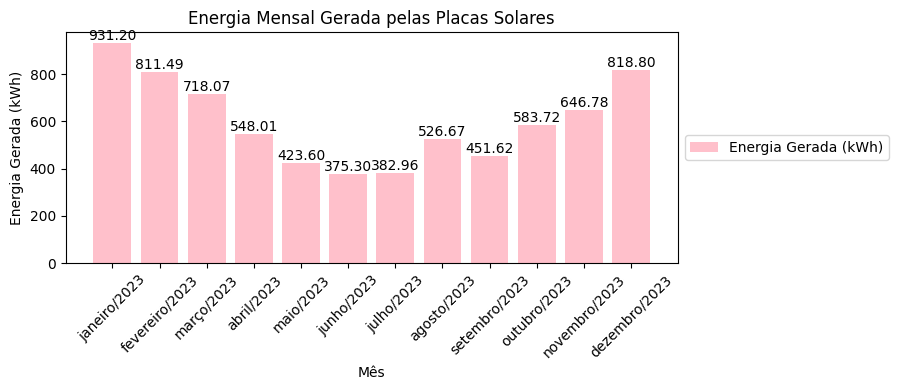

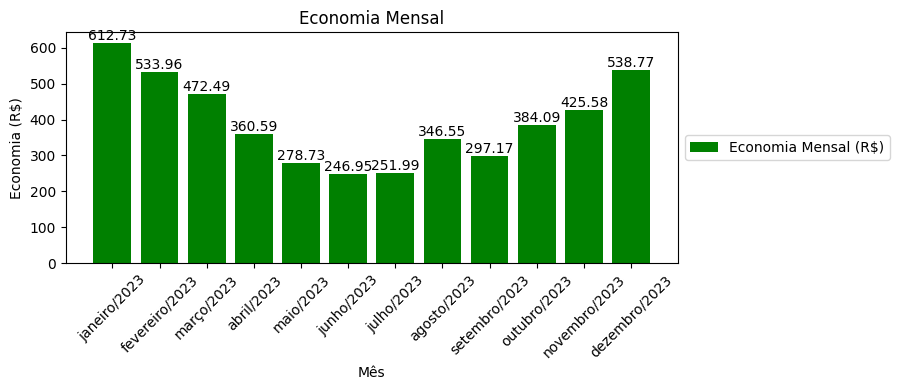

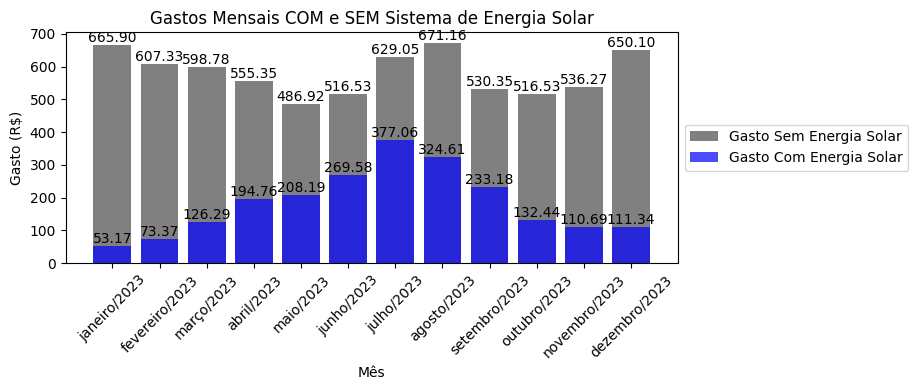

In [12]:
plt.figure(figsize=(7, 4))
bars = plt.bar(df_resultados['Mês'], df_resultados['Energia Gerada (kWh)'], color='pink', label='Energia Gerada (kWh)')
plt.xlabel('Mês')
plt.ylabel('Energia Gerada (kWh)')
plt.title('Energia Mensal Gerada pelas Placas Solares')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')
plt.show()

plt.figure(figsize=(7, 4))
bars = plt.bar(df_resultados['Mês'], df_resultados['Economia Mensal (R$)'], color='green', label='Economia Mensal (R$)')
plt.xlabel('Mês')
plt.ylabel('Economia (R$)')
plt.title('Economia Mensal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')
plt.show()

plt.figure(figsize=(7, 4))
bars1 = plt.bar(df_resultados['Mês'], df_resultados['Gasto Anterior (R$)'], color='gray', label='Gasto Sem Energia Solar')
bars2 = plt.bar(df_resultados['Mês'], df_resultados['Gasto Atual (R$)'], color='blue', label='Gasto Com Energia Solar', alpha=0.7)
plt.xlabel('Mês')
plt.ylabel('Gasto (R$)')
plt.title('Gastos Mensais COM e SEM Sistema de Energia Solar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')
plt.show()